# Load data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
import sys
sys.path.append("..")
from scem import ebm, stein, kernel, util, gen
from scem.datasets import *
import matplotlib.pyplot as plt
from tqdm import notebook as tqdm

In [4]:
dname = "banana"
p = load_data(dname, D=2, noise_std = 0.0, seed=0, itanh=False, whiten=False )

x = p.sample(1000)
x_eval = p.sample(100)

In [5]:
import torch 
import torch.nn as nn
import numpy as np
import torch.distributions as td
    
class GaussianEBM(nn.Module):
    
    def __init__(self, Dx, Dz, Dh):
        
        super().__init__()
        
        self.prior   = td.Normal(torch.zeros(Dz), torch.ones(Dz))
        self.std     = nn.Parameter(torch.zeros(Dx))
        self.layer_1 = nn.Linear(Dz, Dh)
        self.layer_2_mu  = nn.Linear(Dh, Dx)
        self.layer_2_sig = nn.Linear(Dh, Dx)
    
    def forward(self, X, Z):

        logp = self.prior.log_prob(Z).sum(-1)
        logp = logp + self.likelihood(Z).log_prob(X).sum(-1)
        
        return logp
    
    def likelihood(self, Z):
        
        h  = nn.functional.elu(self.layer_1(Z))
        m  = self.layer_2_mu(h)
        s  = nn.functional.softplus(self.std)
        return td.Normal(m, s)
    
    def sample(self, N):
        z = self.prior.sample([N])
        x = self.likelihood(z).sample()
        return x

# dimensionality of model 
Dx = 2
Dz = 2
Dh = 100

lebm = ebm.LatentEBMAdapter(GaussianEBM(Dx, Dz, Dh), var_type_obs='continuous', var_type_latent='continuous')

In [6]:
X = torch.as_tensor(x, dtype=torch.float32)

In [7]:
# define kernel

# KSD kernel on x
med2_x = util.pt_meddistance(X)**2
#kx = kernel.KIMQ(b=-0.5, c=1, s2=med2)
med2_px = torch.tensor([med2_x], requires_grad=True)
k_px = kernel.KGauss(med2_px)

# KCSD kernel on x
med2_qx = torch.tensor([med2_x], requires_grad=True)
k_qx = kernel.KGauss(med2_qx)

# q(z|x)
cs = gen.CSFactorisedGaussian(Dx, Dz, Dh)
# cs = gen.Implicit(Dx, Dz, Dh)
# KCSD kernel on z 
Z = cs.sample(1, X)
Z = Z.squeeze(0)
med2_z = util.pt_meddistance(Z)**2
med2_z = torch.tensor([med2_z], requires_grad=True)
# k_z = kernel.KIMQ(b=-0.5, c=1, s2=med2_z)
k_z = kernel.KGauss(med2_qx)


# approximate score p(x)
approx_score = stein.ApproximateScore(
        lebm.score_joint_obs, cs)
approx_score.n_sample = 100

In [8]:
# optimizer settings
learning_rate_q = 1e-3
weight_decay_q =  0
optimizer_q = torch.optim.Adam(cs.parameters(), lr=learning_rate_q,
                               weight_decay=weight_decay_q)


# optimizer settings for p(x)
learning_rate_p = 1e-3
weight_decay_p  = 0
optimizer_p = torch.optim.Adam(lebm.parameters(), lr=learning_rate_p,
                               weight_decay=weight_decay_p)

optimizer_med2_qx = torch.optim.Adam([med2_qx], lr=learning_rate_q,
                               weight_decay=weight_decay_q)

optimizer_med2_px = torch.optim.Adam([med2_px], lr=learning_rate_p,
                               weight_decay=weight_decay_p)

optimizer_med2_z = torch.optim.Adam([med2_z], lr=learning_rate_q,
                               weight_decay=weight_decay_q)

In [9]:
iter_p = 2000
iter_q = 1
batch_size = 100

In [10]:
def inner_loop(niter, X, cs):
    for i in range(niter):
        Z = cs.sample(1, X)
        Z = Z.squeeze(0)
        
        loss = stein.kcsd_ustat(
            X, Z, lebm.score_joint_latent, k_qx, k_z)
        
        optimizer_q.zero_grad()
        loss.backward(retain_graph=False)
        optimizer_q.step()
        
#         Z = cs.sample(1, X)
#         Z = Z.squeeze(0)
#         loss = -stein.kcsd_ustat(
#             X, Z, lebm.score_joint_latent, k_qx, k_z)
        
#         optimizer_med2_qx.zero_grad()
#         optimizer_med2_z.zero_grad()
#         loss.backward(retain_graph=False)
#         optimizer_med2_qx.step()
#         optimizer_med2_z.step()

def inner_loop(niter, X, cs):
    for i in range(niter):
        Z = cs.sample(1, X)
        Z = Z.squeeze(0)
        
        loss = - (lebm.forward(X, Z) + cs.likelihood(X).entropy().sum(-1)).mean()
        
        optimizer_q.zero_grad()
#         optimizer_p.zero_grad()
        loss.backward(retain_graph=False)
#         optimizer_p.step()
        optimizer_q.step()
        return loss
#         Z = cs.sample(1, X)
#         Z = Z.squeeze(0)
#         loss = -stein.kcsd_ustat(
#             X, Z, lebm.score_joint_latent, k_qx, k_z)
        
#         optimizer_med2_qx.zero_grad()
#         optimizer_med2_z.zero_grad()
#         loss.backward(retain_graph=False)
#         optimizer_med2_qx.step()
#         optimizer_med2_z.step()


losses = []
med2s = []

In [47]:
with tqdm.tqdm(range(3000)) as ts:
    for t in ts:

        # sample data
        perm = torch.randperm(X.shape[0]).detach()
        idx = perm[:batch_size]
        X_ = X[idx].detach()

        # train recognition model and KCSD kernels
        inner_loop(iter_q, X_, cs)
        
        loss = stein.ksd_ustat(X_, approx_score, k_px)  

        Z = cs.sample(1, X_)[0]
#         loss = - lebm.forward(X_,Z).mean()

        losses += [loss.item()]
        med2s  += [med2_px.item(), med2_qx.item(), med2_z.item()],
        ts.set_postfix(loss=loss.item())
    
#         # train model p
        optimizer_p.zero_grad()
        loss.backward(retain_graph=False)
        optimizer_p.step()
        
#         # train KSD kernel
        perm = torch.randperm(X.shape[0]).detach()
        idx = perm[:batch_size]
        X_ = X[idx].detach()
        
        loss = -stein.ksd_ustat(X_, approx_score, k_px)  
        optimizer_med2_px.zero_grad()
        loss.backward(retain_graph=False)
        optimizer_med2_px.step()

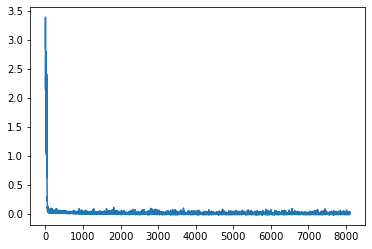

In [48]:
plt.plot(losses)

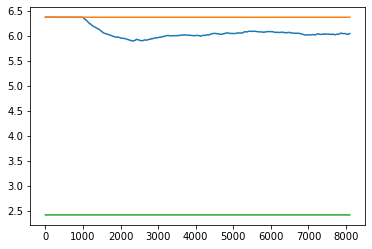

In [49]:
plt.plot(med2s)

In [50]:
# form a grid for numerical normalisation
from itertools import product
ngrid = 20
grid = torch.linspace(-10, 10, ngrid)
xz_eval = torch.tensor(list(product(*[grid]*4)))
x_eval = xz_eval[:,:2]
z_eval = xz_eval[:,2:]

In [51]:
# true log density
E_true = p.logpdf_multiple(torch.tensor(list(product(*[grid]*2))))
E_true -= E_true.max()

In [52]:
# EBM log density
E_eval = lebm(x_eval, z_eval).reshape(ngrid,ngrid,ngrid,ngrid).exp().detach()
E_eval /= E_eval.sum()
E_eval = E_eval.sum(-1).sum(-1)
E_eval.log_()
E_eval -= E_eval.max()
# E_eval = E_eval.sum(-1).sum(-1)

In [53]:
def normalise(E):
    if isinstance(E, np.ndarray):
        E = np.exp(E)
    else:
        E = E.exp()
    E /= E.sum()
    return E

(-10.0, 10.0)

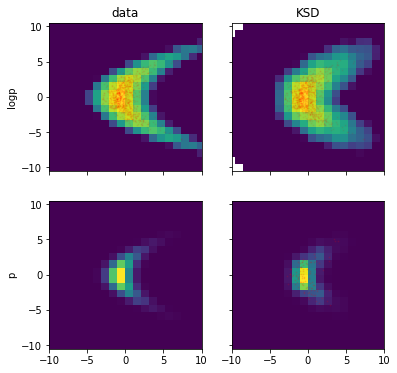

In [54]:
fig, axes = plt.subplots(2,2,figsize=(6,6), sharex=True, sharey=True)


ax = axes[0,0]
ax.pcolor(grid, grid,E_true.reshape(ngrid,ngrid), shading='auto', vmin=-10, vmax=0)
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.05)


ax = axes[1,0]
ax.pcolor(grid, grid,normalise(E_true).reshape(ngrid,ngrid), shading='auto')

ax = axes[0,1]
ax.pcolor(grid, grid,E_eval,shading='auto', vmin=-10, vmax=0, )
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.05)

ax = axes[1,1]
ax.pcolor(grid, grid,normalise(E_eval),shading='auto' )
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.0)
fake_x = lebm.module.sample(100)
ax.scatter(fake_x[:,1], fake_x[:,0], c="r", s=1, alpha=0.1)


axes[0,0].set_ylabel("logp")
axes[1,0].set_ylabel("p")

axes[0,0].set_title("data")
axes[0,1].set_title("KSD")

axes[0,0].set_xlim(-10,10)